<a href="https://colab.research.google.com/github/nermienkh/BMD212_Spring22/blob/main/Copy_of_Refcoco_infer_with_camera_and_voice_p2p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **OFA**
Start to enjoy visual grounding with OFA! 

In [1]:
# clone OFA if there does not exist the repo
%cd /content
!git clone https://github.com/OFA-Sys/OFA.git

/content
Cloning into 'OFA'...
remote: Enumerating objects: 6610, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 6610 (delta 113), reused 171 (delta 86), pack-reused 6384
Receiving objects: 100% (6610/6610), 122.86 MiB | 32.27 MiB/s, done.
Resolving deltas: 100% (2721/2721), done.


## **Download Checkpoint**
We provide a link for our public checkpoint, and you only need to wget it to your workspace. We also provide an alternative below. Choose one as you like!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
from google.colab import drive
drive.mount('/content/Drive')
!mkdir -p /content/OFA/checkpoints
!ln -s /content/Drive/MyDrive/caption.pt /content/OFA/checkpoints/refcocog.pt
'''

In [7]:
%cd /content
!mkdir -p /content/OFA/checkpoints/
#uncomment this part if file is not downloaded and dont run the next cell which point to Drive 
#!wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/checkpoints/refcocog_large_best.pt
#!mv refcocog_large_best.pt OFA/checkpoints/refcocog.pt
#!cp /content/drive/MyDrive/RefCoco-Visualgrounding/refcocog_large_best.pt OFA/checkpoints/refcocog.pt
#ln Make links and symlinks between files or directories.
!cp /content/drive/MyDrive/RefCoco-Visualgrounding/refcocog_large_best.pt /content/OFA/checkpoints/refcocog.pt

/content


## **Install Fairseq**
We advise you to install fairseq by cloning the official repository and running "pip install". 

You should restart the window if you meet the hint of "RESTART RUNTIME". 

In [3]:
# clone Fairseq for installation
%cd /content
!git clone https://github.com/pytorch/fairseq.git -b v0.12.0
%cd /content/fairseq

!pip install --use-feature=in-tree-build ./

/content
Cloning into 'fairseq'...
remote: Enumerating objects: 34534, done.
remote: Total 34534 (delta 0), reused 0 (delta 0), pack-reused 34534
Receiving objects: 100% (34534/34534), 24.06 MiB | 28.91 MiB/s, done.
Resolving deltas: 100% (25109/25109), done.
Note: switching to '6795311bfeb9d39fe11a62803184b81acb66509e'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

/content/fairseq
DEPRECATION: In-tree builds are now the default. pip 22.1 will enforce this behaviour change. A possible replacement is to remove the --use-fea

## **Preparation**
Below you just need to import required packages, and check whether to use GPU or FP16. 

In [10]:
%cd /content/OFA
!sed '1d' requirements.txt | xargs -I {} pip install {}

/content/OFA
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simpl

In [11]:
import torch
import numpy as np
!pip install g2p-en #added
from fairseq import utils, tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.refcoco import RefcocoTask
from models.ofa import OFAModel
from PIL import Image

# Register refcoco task
tasks.register_task('refcoco', RefcocoTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Build Model**
Below you can build your model and load the weights from the given checkpoint, and also build a generator. 

In [12]:
# Load pretrained ckpt & config
overrides={"bpe_dir":"utils/BPE"}
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths('checkpoints/refcocog.pt'),
        arg_overrides=overrides
    )

cfg.common.seed = 7
cfg.generation.beam = 5
cfg.generation.min_len = 4
cfg.generation.max_len_a = 0
cfg.generation.max_len_b = 4
cfg.generation.no_repeat_ngram_size = 3

# Fix seed for stochastic decoding
if cfg.common.seed is not None and not cfg.generation.no_seed_provided:
    np.random.seed(cfg.common.seed)
    utils.set_torch_seed(cfg.common.seed)
    

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## **Preprocess**
We demonstrate the required transformation fucntions for preprocessing inputs.

In [13]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text.lower()),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for refcoco task
patch_image_size = cfg.task.patch_image_size
def construct_sample(image: Image, text: str):
    
    w,h = image.size

    w_resize_ratio = torch.tensor(patch_image_size / w).unsqueeze(0)
    h_resize_ratio = torch.tensor(patch_image_size / h).unsqueeze(0)
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(' which region does the text " {} " describe?'.format(text), append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "image":image # added
        ,

        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        },
        "w_resize_ratios": w_resize_ratio,
        "h_resize_ratios": h_resize_ratio,
        "region_coords": torch.randn(1, 4)
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


## **Run Inference**
Download an image and run the following scripts to generate the result.

In [ ]:
'''
# Download an image from COCO or you can use other images with wget
#! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/datasets/refcoco/pokemon.jpg
#! mv pokemon.jpg  test.jpg
#image = Image.open('./test.jpg')
#image = Image.open('/content/collection.jpg')

#text = "an orange turtle-like pokemon with round head"
text = "where is the laptop?"

# Construct input sample & preprocess for GPU if cuda available
#sample = construct_sample(image, text)
#sample = utils.move_to_cuda(sample) if use_cuda else sample
#sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Run eval step for refcoco
with torch.no_grad():
    result, scores = eval_step(task, generator, models, sample)
'''

'\n# Download an image from COCO or you can use other images with wget\n#! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/datasets/refcoco/pokemon.jpg\n#! mv pokemon.jpg  test.jpg\n#image = Image.open(\'./test.jpg\')\n#image = Image.open(\'/content/collection.jpg\')\n\n#text = "an orange turtle-like pokemon with round head"\ntext = "where is the laptop?"\n\n# Construct input sample & preprocess for GPU if cuda available\n#sample = construct_sample(image, text)\n#sample = utils.move_to_cuda(sample) if use_cuda else sample\n#sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample\n\n# Run eval step for refcoco\nwith torch.no_grad():\n    result, scores = eval_step(task, generator, models, sample)\n'

In [ ]:
'''
import cv2
import numpy
from google.colab.patches import cv2_imshow

img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
rect=(int(result[0]["box"][0]), int(result[0]["box"][1]),int(result[0]["box"][2]), int(result[0]["box"][3]))

#	cv.rectangle(	img, pt1, pt2, color[, thickness[, lineType[, shift]]]	) -> 	img
cv2.rectangle(
    img,
    (rect[0], rect[1]),
    (rect[2], rect[3]),
    (0, 255, 0),
    3
)
cv2_imshow(img)
'''

'\nimport cv2\nimport numpy\nfrom google.colab.patches import cv2_imshow\n\nimg = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)\nrect=(int(result[0]["box"][0]), int(result[0]["box"][1]),int(result[0]["box"][2]), int(result[0]["box"][3]))\n\n#\tcv.rectangle(\timg, pt1, pt2, color[, thickness[, lineType[, shift]]]\t) -> \timg\ncv2.rectangle(\n    img,\n    (rect[0], rect[1]),\n    (rect[2], rect[3]),\n    (0, 255, 0),\n    3\n)\ncv2_imshow(img)\n'

In [14]:

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline




# model helper function to run detection on image
def model_helper(img,info,  width=1, height=1):
  # Construct input sample & preprocess for GPU if cuda available
  sample = construct_sample(img, info)
  sample = utils.move_to_cuda(sample) if use_cuda else sample
  sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width = img.size
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  # Run eval step for refcoco
  with torch.no_grad():
    result, scores = eval_step(task, generator, models, sample)
  return result, width_ratio, height_ratio,scores


# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  #I have removed the mode to be detected on run time as i changed the overlay array size from 4 to 1 channel so we don't have an RGBA image anymore
  bbox_PIL = PIL.Image.fromarray(bbox_array )
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes





  # JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
     

Prepare Speech input

In [15]:
#for speech
!pip install ffmpeg-python
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

!pip install SpeechRecognition
import speech_recognition as sr
sr.__version__



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 32.1 MB/s eta 0:00:00


'3.10.0'

In [16]:
#JavaScript to properly create our Speech using our Microphone as input

"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""


AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [17]:
#record Speech
audio, srr = get_audio()   

In [18]:
#Convert Speech to text

#Google Web Speech API,
#Caution: The default key provided by SpeechRecognition is for testing purposes only,
# and Google may revoke it at any time. It is not a good idea to use the Google Web Speech API in production.
# Even with a valid API key, you’ll be limited to only 50 requests per day, and there is no way to raise this quota. Fortunately, 
#SpeechRecognition’s interface is nearly identical for each API,
# so what you learn today will be easy to translate to a real-world project.

#supported languages
#https://cloud.google.com/speech-to-text/docs/speech-to-text-supported-languages

r = sr.Recognizer()
myaudio=sr.AudioData(audio,srr,4) #2 in chrome 4 in firefox
text= r.recognize_google(myaudio, show_all=False)    
print(text)

where is my notebook


Main Working Loop 

In [ ]:
!pip install pulse2percept

In [23]:
import pulse2percept as p2p
from pulse2percept.stimuli import ImageStimulus
#Scoreboard model of [Beyeler2019] (standalone model) Implements the scoreboard model described in [Beyeler2019], where all percepts are Gaussian blobs.
modelp2p = p2p.models.ScoreboardModel(xrange=(-7, 7), yrange=(-7, 7), xystep=0.1)
modelp2p.build()

from pulse2percept.implants import AlphaAMS
implant = AlphaAMS()

In [58]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # i added this line here as the Image variable is getting overrided  each iteration and  idk why yet?!
    from PIL import Image
    # convert JS response to OpenCV Image
    Opencv_frame = js_to_image(js_reply["img"])
    #convert image to gray scale
    gray = cv2.cvtColor(Opencv_frame, cv2.COLOR_BGR2GRAY)
     # convert  OpenCV Image to PIL
    frame = Image.fromarray(gray)
    #generate initial mask 
    #mask = np.zeros(Opencv_frame.shape, dtype="uint8")

    # For reversing the operation:
    #im_np = np.asarray(im_pil)
    # create transparent overlay for bounding box
    bbox_array = np.zeros([frame.size[1],frame.size[0],1], dtype=np.uint8)
  

    # call our model helper on video frame
    result, width_ratio, height_ratio,score = model_helper(frame,text)

    # loop through detections and draw them on transparent overlay image
    rect=(int(result[0]["box"][0]), int(result[0]["box"][1]),int(result[0]["box"][2]), int(result[0]["box"][3]))
  
    #left, top, right, bottom = int(rect[0] * width_ratio), int(rect[1] * height_ratio), int(rect[2] * width_ratio), int(rect[3] * height_ratio)
    left, top, right, bottom = int(rect[0] ), int(rect[1] ), int(rect[2] ), int(rect[3] )
    #trnasform mask based on the detected object
    #mask=cv2.rectangle(mask, (left, top), (right, bottom), 255, -1)
   
    bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), (255, 255, 255),-1)
    bbox_array = cv2.bitwise_and(np.asarray(frame),np.asarray( frame), mask=bbox_array)
    
    im = Image.fromarray(bbox_array)
    im.save("object.png")

    #pulse2percept part
    
    stim = ImageStimulus("object.png")
    stim_edge = stim.filter('canny')
    implant.stim = stim_edge.resize(implant.shape)
    #Then the implant can be passed to the model’s predict_percept method:
    percept_gray = modelp2p.predict_percept(implant)
     
    np_img = np.squeeze(percept_gray.data, axis=2)  # axis=2 is channel dimension 
   

    # convert overlay of bbox into bytes
    #bbox_bytes = bbox_to_bytes((percept_gray.data *255).astype(np.uint8))
    bbox_bytes = bbox_to_bytes((np_img*255).astype(np.uint8))

    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

    
  

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [50]:
np.squeeze(percept_gray.data,axis=2).shape

(141, 141)

In [54]:
type(np_img)

numpy.ndarray

In [55]:
pil_img

ValueError: ignored

<PIL.Image.Image image mode=F size=141x141 at 0x7FC82E479880>

<Axes: >

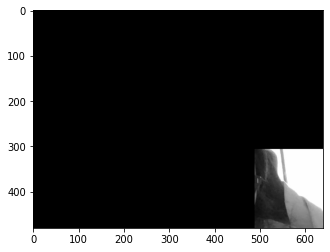

In [28]:
stim.plot()